In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot


KeyboardInterrupt



In [2]:
dataset_path = 'example-dataset'
image_size = (128, 128)
batch_size = 100
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        dataset_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='sparse')

Found 1708 images belonging to 5 classes.


In [3]:
#label dictionary
label_dict = {0: 'sadness',
              1: 'fear',
              2: 'trust',
              3: 'surprise',
              4: 'happiness',
              }

In [4]:
batchX, batchy = train_generator.next()
norm_batchX = (batchX.astype(np.float32)-127.5) / 127.5
print('Batch shape=%s, min=%.3f, max=%.3f' % (norm_batchX.shape, norm_batchX.min(), norm_batchX.max()))
print('Batch shape=%s, min=%.3f, max=%.3f' % (norm_batchX.shape, norm_batchX.min(), norm_batchX.max()))

Batch shape=(100, 128, 128, 3), min=-1.000, max=1.000
Batch shape=(100, 128, 128, 3), min=-1.000, max=1.000


In [5]:
batchy

array([3., 2., 3., 3., 2., 3., 3., 1., 3., 1., 3., 3., 1., 1., 4., 4., 3.,
       3., 3., 1., 1., 1., 2., 3., 3., 3., 3., 3., 3., 1., 1., 0., 2., 2.,
       3., 2., 3., 3., 3., 3., 2., 3., 1., 3., 1., 3., 3., 1., 3., 3., 1.,
       0., 1., 3., 1., 1., 1., 2., 0., 3., 3., 2., 2., 1., 1., 1., 2., 2.,
       4., 3., 1., 3., 3., 3., 1., 2., 4., 3., 3., 3., 1., 3., 3., 0., 3.,
       1., 3., 3., 3., 3., 3., 4., 3., 3., 3., 0., 1., 3., 3., 3.],
      dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


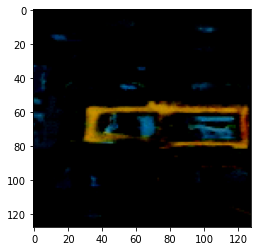

surprise


In [6]:
import random
rand_int = random.randint(0,batch_size-1)

img = (norm_batchX[rand_int])
plt.imshow(img)
plt.show()
print(label_dict[batchy[rand_int]])

In [7]:
# define the standalone discriminator model
def define_discriminator(in_shape=(128,128,3), n_classes=5):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	
	# downsample to 64x64 note we do not normalize here
	fe = Conv2D(16, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
 
	# Normalize
	fe = Conv2D(32, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)

	# downsample to 32x32
	fe = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
 
	# Normalize
	fe = Conv2D(128, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
 
 	# downsample to 16x16
	fe = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
 
  # Normalize
	fe = Conv2D(512, (3,3), padding='same', kernel_initializer=init)(fe)
	fe = BatchNormalization()(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.5)(fe)
	
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid')(fe)
	# class label output
	out2 = Dense(n_classes, activation='softmax')(fe)
	# define model
	model = Model(in_image, [out1, out2])
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model
 
# define the standalone generator model
def define_generator(latent_dim, n_classes=5):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 100)(in_label)
	# linear multiplication
	n_nodes = 8 * 8
	li = Dense(n_nodes, kernel_initializer=init)(li)
	# reshape to additional channel
	li = Reshape((8, 8, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 16x16 image
	n_nodes = 384 * 8 * 8
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = Activation('relu')(gen)
	gen = Reshape((8, 8, 384))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
 
	# upsample to 32x32
	gen = Conv2DTranspose(384, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)

	# upsample to 64x64
	gen = Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)

	# upsample to 64x64
	gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
	gen = BatchNormalization()(gen)
	gen = Activation('relu')(gen)
	
	# upsample to 128x128
	gen = Conv2DTranspose(3, (5,5), strides=(2,2) padding='same', kernel_initializer=init)(gen)
	out_layer = Activation('tanh')(gen)
	
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model
 
  # define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
  # make weights in the discriminator not trainable
  for layer in d_model.layers:
    if not isinstance(layer, BatchNormalization):
      layer.trainable = False
  # connect the outputs of the generator to the inputs of the discriminator
  gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
  model = Model(g_model.input, gan_output)
	# compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
  return model
 
# load images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	print(X.shape, trainy.shape)
	return [X, trainy]
 
# select real samples
def generate_real_samples(data_generator, n_samples):
	# select images and labels
  X, labels = train_generator.next()

  if(len(labels) < n_samples):
    print("Generator exhausted. Cycling generator!")
    train_generator.on_epoch_end()
    X, labels = train_generator.next()
	 
  X = expand_dims(X, axis=-1)
  X = X.astype('float32')
	# scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
	# generate class labels
  y = ones((n_samples, 1))
  return [X, labels], y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=5):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	[X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, :])
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	print('>Saved: %s' % (filename1))
	# save the generator model
	# filename2 = 'model_%04d.h5' % (step+1)
	#g_model.save(filename2)
	#print('>Saved: %s and %s' % (filename1, filename2))
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, data_generator, latent_dim, n_epochs=100, n_batch=200):
	# calculate the number of batches per training epoch
	bat_per_epo = int(data_generator.samples / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_steps):
		# get randomly selected 'real' samples
		[X_real, labels_real], y_real = generate_real_samples(data_generator, half_batch)
		# update discriminator model weights
		_,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
		# generate 'fake' examples
		[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model weights
		_,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
		# prepare points in latent space as input for the generator
		[z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		_,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
		# summarize loss on this batch
		print('>%d/%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, n_steps, d_r1,d_r2, d_f,d_f2, g_1,g_2))
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, latent_dim)

SyntaxError: invalid syntax (4130626594.py, line 95)

In [ ]:
# size of the latent space
latent_dim = 110
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
#dataset = load_real_samples()
# train model
train(generator, discriminator, gan_model, train_generator, latent_dim, 200)

In [ ]:
generator.save("model.h5")

In [ ]:
# example of loading the generator model and generating images
from math import sqrt
from numpy import asarray
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_class):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = asarray([n_class for _ in range(n_samples)])
    return [z_input, labels]
 
# create and save a plot of generated images
def save_plot(examples, n_examples):
    # plot images
    for i in range(n_examples):
        # define subplot
        pyplot.subplot(sqrt(n_examples), sqrt(n_examples), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, :])
    pyplot.show()

def single_plot(data, path):
    # define subplot
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(data[0, :, :, :])
    pyplot.savefig(IMAGE_PATH)
    pyplot.close()
 
# load model
model = load_model('model.h5')
latent_dim = 100
n_examples = 1 # must be a square
n_class = 2 # sneaker [0-4]
# generate images
latent_points, labels = generate_latent_points(latent_dim, n_examples, n_class)
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result

IMAGE_PATH = "original.png"

print(label_dict[n_class])
save_plot(X, n_examples)
single_plot(X, IMAGE_PATH)